# FM on Spark demo

## Initialisation

Load the file.

In [9]:
sc.addPyFile("./fm/fm_parallel_sgd.py")

In [10]:
import fm_parallel_sgd as fm
from fm_parallel_sgd import *

Set some matplotlib parameters for plotting figures directly in the notebook:

In [11]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize']=(16.0, 12.0)

## Loading the dataset

The dataset should be a RDD of LabeledPoints.
Labels should be -1 or 1.
Features should be either SparseVector or DenseVector from mllib.linalg library


The Adult dataset (a9a) is used to predict who has a salary over $50.000, based on various information (Platt, 1998).
You can download it here : [a9a](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#a9a)

123 features - 11% sparse

In [12]:
nrPartitions = 5
trainPath = "/path/to/a9a_train_dataset/a9a"
trainAll = MLUtils.loadLibSVMFile(sc, trainPath, numFeatures=123).repartition(nrPartitions)
testPath = "/path/to/a9a_test_dataset/a9a.t"
test = MLUtils.loadLibSVMFile(sc, testPath, numFeatures=123)

print trainAll.count()
print test.count()
print trainAll.first()

32561
16281
(-1.0,(123,[3,5,15,21,35,39,47,62,66,72,73,75,79,82],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))


## Training

### trainFM_parallel_sgd

Train a Factorization Machine model using parallel stochastic gradient descent.

In [13]:
?trainFM_parallel_sgd

In [14]:
temp = time.time()
model = trainFM_parallel_sgd (sc, trainAll, iterations=1, iter_sgd= 1, alpha=0.01, regParam=0.01, factorLength=4,\
                      verbose=False, savingFilename = None, evalTraining=None)
print 'time :'; print  time.time()-temp;

time :
3.86300396919


### evaluate(test, model)

Evaluate your model on a test set.

In [15]:
?evaluate

In [16]:
print evaluate(test, model)

(0.68259001730250368, 0.86804791049703911, 0.44670760423319972, 0.13751608642006091, 0.8245807997051778)


#### verbose=True

Split the rdd into a training set and a validation set.
Print the evaluation after each iteration.

#### savingFilename (string)

Saves the model in a pickle file after each iteration. The files are saved in the current directory.
The files are named 'savingFilename\_iteration_#'

In [7]:
temp = time.time()
trainFM_parallel_sgd (sc, trainAll, iterations=5, iter_sgd= 3, alpha=0.01, regParam=0.01, factorLength=4,\
                      verbose=True, savingFilename = 'a9a', evalTraining=None)
print 'total time :'; print  time.time()-temp;

iter 	time 	train_logl 	val_logl
0 	0 	0.854109 	0.852435
1 	3 	0.371213 	0.377127
2 	15 	0.341775 	0.347274
3 	20 	0.335254 	0.340015
4 	25 	0.332495 	0.336999
5 	31 	0.330852 	0.335061
Train set: 
(rtv_pr_auc, rtv_auc, logl, mse, accuracy)
(0.74938273730915506, 0.90361606949579976, 0.33085180499849454, 0.10461887890788814, 0.8478847191184403)
Validation set:
(0.75222550799424182, 0.90126862508007655, 0.33506090564741109, 0.10632780636263023, 0.8447101558952625)
total time :
43.451184988


#### Load one of the saved model

In [8]:
model = loadModel('a9a_iteration_5')

In [9]:
evaluate(test, model)

(0.74337068316050736,
 0.90144704622121363,
 0.33113058313184407,
 0.10467371226219223,
 0.8501934770591487)

#### evalTraining

Used to plot the evaluation (train+validation) during the training

You need to create an instance of the class evaluation first.

You can set evalTraining.modulo = 5 to evaluate the model after each 5 iterations for example (default is 1)

iter 	time 	train_logl 	val_logl
0 	0 	0.876928 	0.878577
1 	4 	0.521640 	0.514907
2 	7 	0.390978 	0.380574
3 	10 	0.357289 	0.347291
4 	13 	0.345249 	0.335896
5 	17 	0.339452 	0.331161
6 	20 	0.336306 	0.328621
7 	24 	0.334525 	0.326969
8 	28 	0.332701 	0.325760
9 	32 	0.331740 	0.324981
10 	35 	0.330733 	0.324522
Train set: 
MSE: 0.104508 
logl: 0.330733 
rtv_pr_auc: 0.750666 
rtv_auc: 0.903780 
Accuracy: 0.903780

Validation set: 
MSE: 0.101870 
logl: 0.324522 
rtv_pr_auc: 0.759833 
rtv_auc: 0.906200 
Accuracy: 0.906200

total time
40.7177088261


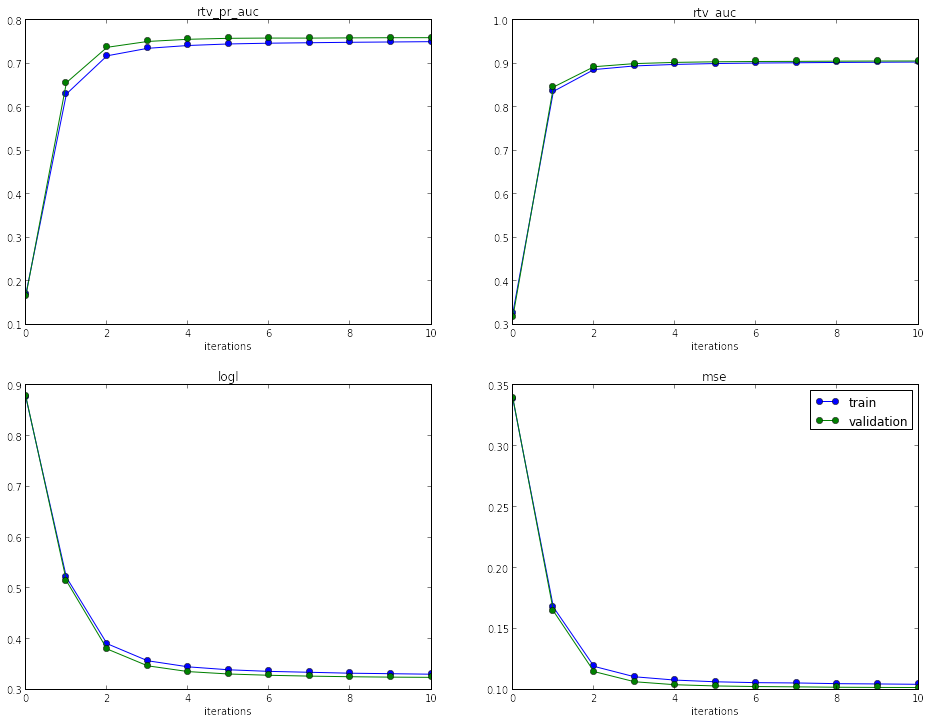

In [6]:
temp = time.time()

evalTraining = evaluation(trainAll)
evalTraining.modulo = 1
trainFM_parallel_sgd(sc, trainAll, iterations=10, iter_sgd=1, verbose = True, evalTraining=evalTraining)
print 'total time'
print  time.time()-temp

## Plotting

Let's plot the different parameters using a sample of the training set

In [18]:
trainSample = trainAll.sample(False, 0.1)

##### plotAlpha(sc, data, alpha_list, iterations, iter_sgd, regParam, factorLength)

Specify the list of alpha you want to plot in the alpha_list

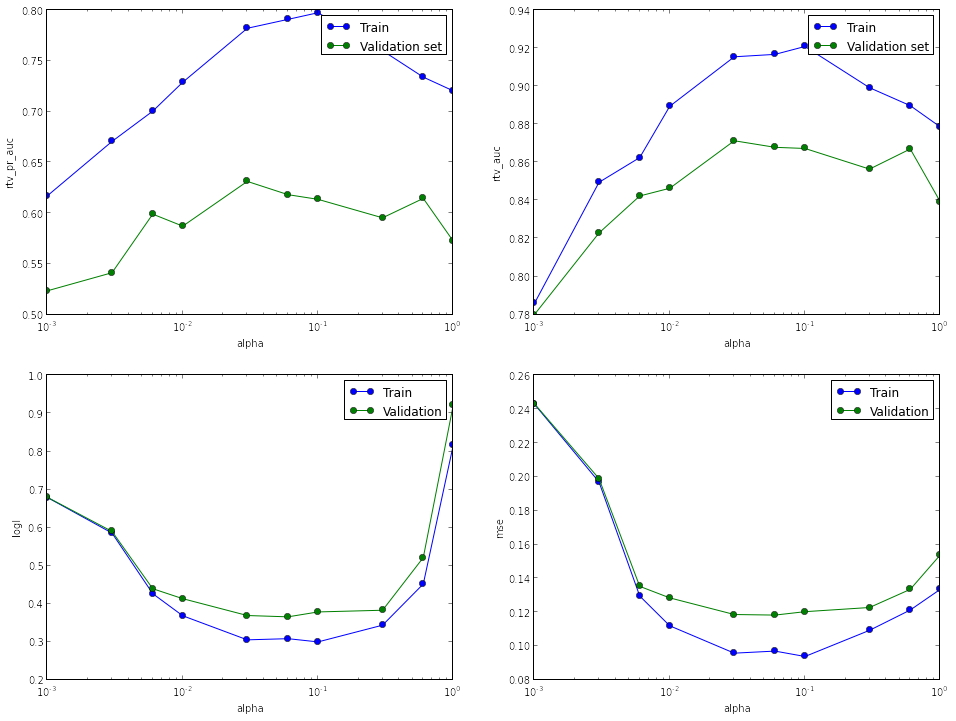

best alpha :  0.060000
best logloss :  0.365493


In [18]:
model = plotAlpha(sc, trainSample, iterations=10, iter_sgd=1, alpha_list = [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1])

##### plotFactorLength(sc, data, factorLength_list, iterations, iter_sgd, alpha, regParam)

Specify the list of factor length you want to plot in the factorLength_list

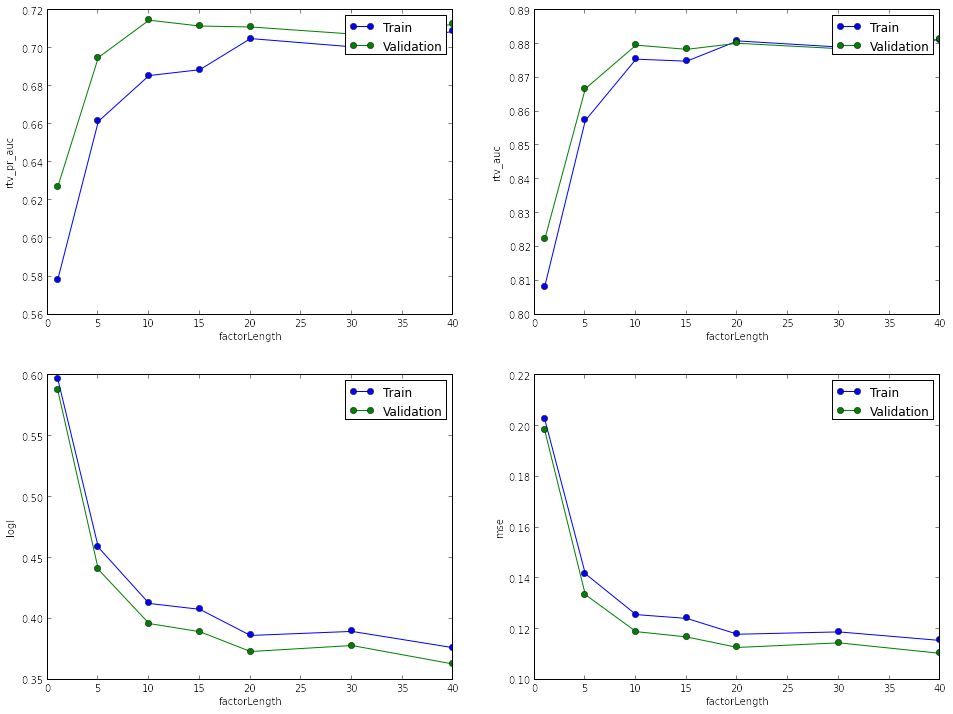

best factor length :  40.000000
best logloss :  0.362929


In [19]:
model = plotFactorLength(sc, trainSample, factorLength_list = [1,5, 10, 15,20, 30, 40],\
              iterations=5, iter_sgd=1, alpha=0.01, regParam=0.)

##### plotRegParam(sc, data, regParam_list, iterations, iter_sgd, alpha, factorLength)

Specify the list of factor length you want to plot in the factorLength_list

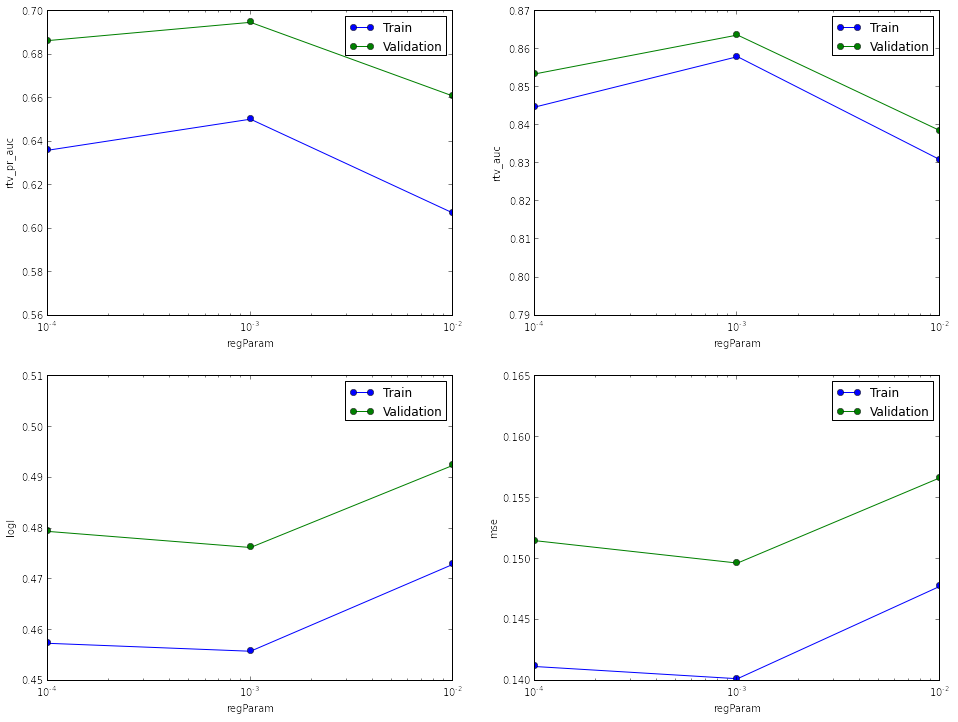

best Regularization Parameter :  0.001000
best logloss :  0.476279


In [24]:
model = plotRegParam(sc, trainSample, regParam_list = [0, 0.0001, 0.001, 0.01], iterations=5, iter_sgd=1, alpha=0.01, factorLength=4)

##### plotAlpha_RegParam(sc, trainAll, alpha_list, regParam_list, iterations, iter_sgd)

Specify the alpha_list and the factorLength_list to plot a color map of the best parameters. The brighter is the lower logloss.

LOGL :
[[ 0.48365715  0.47504976  0.47270356  0.48155732]
 [ 0.3512915   0.35090307  0.35290735  0.35262541]
 [ 0.35457726  0.35305376  0.35368596  0.35214536]
 [ 0.35739485  0.35609445  0.3624781   0.36309322]]
best alpha :  0.030000
best Regularization Parameter :  0.000100
best logloss :  0.350903


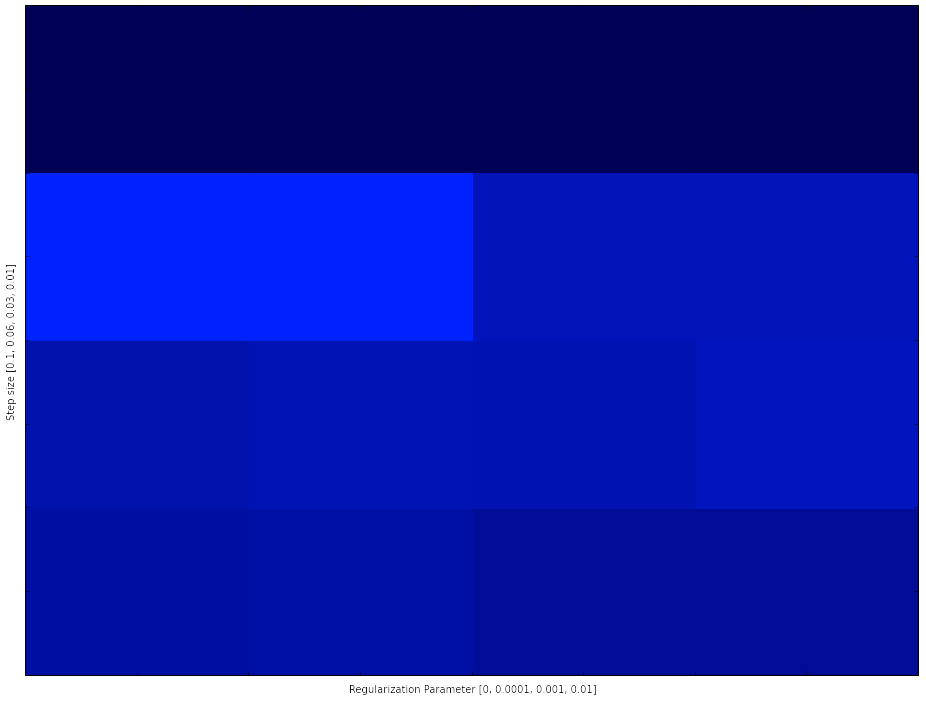

In [19]:
bestModel = plotAlpha_RegParam(sc, trainSample, alpha_list = [0.01, 0.03, 0.06, 0.1],\
                       regParam_list = [0, 0.0001, 0.001, 0.01],\
                       iterations=5, iter_sgd=1)

In [20]:
evaluate(test, bestModel)

(0.7215559809865818,
 0.88628203109628201,
 0.35258416805081105,
 0.11055359105525277,
 0.8438056630428107)

### Predictions

To calculate the probabilities according to the model for a test set, call predict(data, model). This return a RDD with probability scores.

In [21]:
prediction = predictFM(test, bestModel)
prediction.take(5)

[0.039436079284176535,
 0.24362765016787755,
 0.29865309772902715,
 0.77342881893026327,
 0.035537110201779229]